# Thrones2Vec

© Yuriy Guts, 2016

Using only the raw text of [A Song of Ice and Fire](https://en.wikipedia.org/wiki/A_Song_of_Ice_and_Fire), we'll derive and explore the semantic properties of its words.

## Imports

In [1]:
from __future__ import absolute_import, division, print_function

In [2]:
import codecs
import glob
import logging
import multiprocessing
import os
import pprint
import re

In [3]:
import nltk
import gensim.models.word2vec as w2v
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf

In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


**Set up logging**

In [5]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

**Download NLTK tokenizer models (only the first time)**

In [6]:
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /home/plexadmin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/plexadmin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Prepare Corpus

**Load books from files**

In [159]:
book_filenames = sorted(glob.glob("data/*.txt"))

In [160]:
print("Found books:")
book_filenames

Found books:


['data/got1.txt',
 'data/got2.txt',
 'data/got3.txt',
 'data/got4.txt',
 'data/got5.txt']

**Combine the books into one string**

In [161]:
corpus_raw = u""
for book_filename in book_filenames:
    print("Reading '{0}'...".format(book_filename))
    with codecs.open(book_filename, "r", "utf-8") as book_file:
        corpus_raw += book_file.read()
    print("Corpus is now {0} characters long".format(len(corpus_raw)))
    print()

Reading 'data/got1.txt'...
Corpus is now 1770659 characters long

Reading 'data/got2.txt'...
Corpus is now 4071041 characters long

Reading 'data/got3.txt'...
Corpus is now 6391405 characters long

Reading 'data/got4.txt'...
Corpus is now 8107945 characters long

Reading 'data/got5.txt'...
Corpus is now 9719485 characters long



**Split the corpus into sentences**

In [162]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [163]:
raw_sentences = tokenizer.tokenize(corpus_raw)

In [164]:
#convert into a list of words
#rtemove unnnecessary,, split into words, no hyphens
#list of words
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    return words

In [165]:
#sentence where each word is tokenized
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [166]:
words = []
for sentense in sentences:
    for word in sentense:
        words.append(word)

In [167]:
print(raw_sentences[5])
print(sentence_to_wordlist(raw_sentences[5]))

Heraldic crest by Virginia Norey.
[u'Heraldic', u'crest', u'by', u'Virginia', u'Norey']


In [72]:
token_count = sum([len(sentence) for sentence in sentences])
print("The book corpus contains {0:,} tokens".format(token_count))

The book corpus contains 1,818,103 tokens


In [73]:
print("Number of words:", len(words))

Number of words: 1818103


## Train Word2Vec

In [21]:
#ONCE we have vectors
#step 3 - build model
#3 main tasks that vectors help with
#DISTANCE, SIMILARITY, RANKING

# Dimensionality of the resulting word vectors.
#more dimensions, more computationally expensive to train
#but also more accurate
#more dimensions = more generalized
num_features = 300
# Minimum word count threshold.
min_word_count = 3

# Number of threads to run in parallel.
#more workers, faster we train
num_workers = multiprocessing.cpu_count()

# Context window length.
context_size = 7

# Downsample setting for frequent words.
#0 - 1e-5 is good for this
downsampling = 1e-3

# Seed for the RNG, to make the results reproducible.
#random number generator
#deterministic, good for debugging
seed = 1

In [22]:
thrones2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [23]:
thrones2vec.build_vocab(sentences)

2017-05-01 22:47:27,999 : INFO : collecting all words and their counts
2017-05-01 22:47:28,000 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-05-01 22:47:28,028 : INFO : PROGRESS: at sentence #10000, processed 140984 words, keeping 10280 word types
2017-05-01 22:47:28,057 : INFO : PROGRESS: at sentence #20000, processed 279730 words, keeping 13558 word types
2017-05-01 22:47:28,085 : INFO : PROGRESS: at sentence #30000, processed 420336 words, keeping 16598 word types
2017-05-01 22:47:28,120 : INFO : PROGRESS: at sentence #40000, processed 556581 words, keeping 18324 word types
2017-05-01 22:47:28,147 : INFO : PROGRESS: at sentence #50000, processed 686247 words, keeping 19714 word types
2017-05-01 22:47:28,179 : INFO : PROGRESS: at sentence #60000, processed 828497 words, keeping 21672 word types
2017-05-01 22:47:28,212 : INFO : PROGRESS: at sentence #70000, processed 973830 words, keeping 23093 word types
2017-05-01 22:47:28,243 : INFO : PROGRESS: at 

In [24]:
print("Word2Vec vocabulary length:", len(thrones2vec.wv.vocab))

Word2Vec vocabulary length: 17277


**Start training, this might take a minute or two...**

In [25]:
#train model on sentneces
thrones2vec.train(sentences, total_examples=thrones2vec.corpus_count, epochs=thrones2vec.iter)

2017-05-01 22:47:31,011 : INFO : training model with 12 workers on 17277 vocabulary and 300 features, using sg=1 hs=0 sample=0.001 negative=5 window=7
2017-05-01 22:47:32,020 : INFO : PROGRESS: at 12.01% examples, 831456 words/s, in_qsize 24, out_qsize 0
2017-05-01 22:47:33,034 : INFO : PROGRESS: at 22.87% examples, 797125 words/s, in_qsize 23, out_qsize 0
2017-05-01 22:47:34,046 : INFO : PROGRESS: at 36.86% examples, 847803 words/s, in_qsize 24, out_qsize 0
2017-05-01 22:47:35,051 : INFO : PROGRESS: at 50.25% examples, 872343 words/s, in_qsize 24, out_qsize 0
2017-05-01 22:47:36,048 : INFO : PROGRESS: at 63.17% examples, 881164 words/s, in_qsize 24, out_qsize 0
2017-05-01 22:47:37,050 : INFO : PROGRESS: at 76.66% examples, 888367 words/s, in_qsize 24, out_qsize 0
2017-05-01 22:47:38,054 : INFO : PROGRESS: at 87.86% examples, 874510 words/s, in_qsize 22, out_qsize 0
2017-05-01 22:47:38,890 : INFO : worker thread finished; awaiting finish of 11 more threads
2017-05-01 22:47:38,897 : INF

7021133

**Save to file, can be useful later**

In [26]:
if not os.path.exists("trained"):
    os.makedirs("trained")

In [27]:
thrones2vec.save(os.path.join("trained", "thrones2vec.w2v"))

2017-05-01 22:47:41,034 : INFO : saving Word2Vec object under trained/thrones2vec.w2v, separately None
2017-05-01 22:47:41,035 : INFO : not storing attribute syn0norm
2017-05-01 22:47:41,035 : INFO : not storing attribute cum_table
2017-05-01 22:47:41,195 : INFO : saved trained/thrones2vec.w2v


## Explore the trained model.

In [28]:
thrones2vec = w2v.Word2Vec.load(os.path.join("trained", "thrones2vec.w2v"))

2017-05-01 22:47:43,406 : INFO : loading Word2Vec object from trained/thrones2vec.w2v
2017-05-01 22:47:43,586 : INFO : loading wv recursively from trained/thrones2vec.w2v.wv.* with mmap=None
2017-05-01 22:47:43,587 : INFO : setting ignored attribute syn0norm to None
2017-05-01 22:47:43,588 : INFO : setting ignored attribute cum_table to None
2017-05-01 22:47:43,589 : INFO : loaded trained/thrones2vec.w2v


### Compress the word vectors into 2D space and plot them

In [29]:
#squash dimensionality to 2
#https://www.oreilly.com/learning/an-illustrated-introduction-to-the-t-sne-algorithm
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

In [30]:
#put it all into a giant matrix
all_word_vectors_matrix = thrones2vec.wv.syn0

**Train t-SNE, this could take a minute or two...**

In [31]:
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

**Plot the big picture**

In [83]:
words = {}
for word in list(thrones2vec.wv.vocab.keys()):
        words[word] = all_word_vectors_matrix_2d[thrones2vec.wv.vocab[word].index][0], all_word_vectors_matrix_2d[thrones2vec.wv.vocab[word].index][1]
       

In [84]:
points = pd.DataFrame.from_dict(words, orient='index')
points.reset_index(level=0, inplace=True)
points.columns = ["word", "x", "y"]
points

,word,x,y
0,fawn,-3.841830,-1.171221
1,raining,1.681726,0.162291
2,writings,-2.434467,-4.913509
3,Ysilla,-2.846905,-3.386993
4,realms,-1.635733,-0.718914
5,hordes,-1.034758,-5.594964
6,mustachio,1.240384,-3.033805
7,Greyjoy,0.333108,2.146823
8,yellow,3.806031,-0.268858
9,four,-4.766552,-3.414439


In [85]:
sns.set_context("poster")

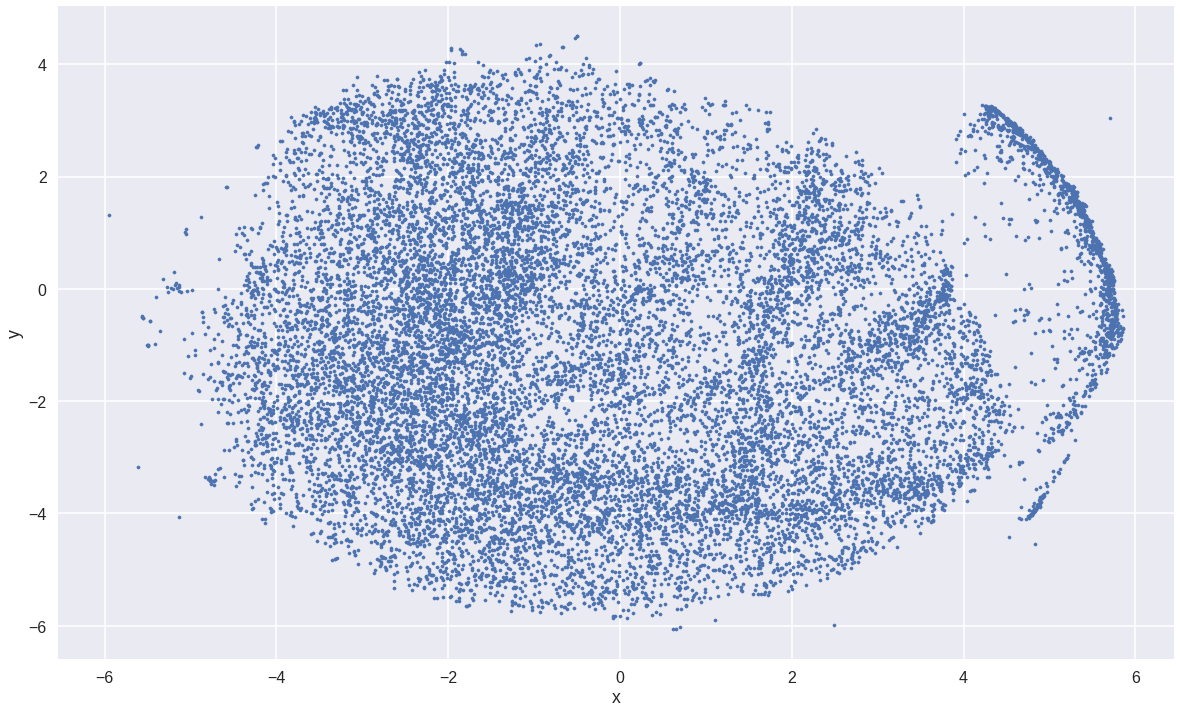

In [86]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

**Zoom in to some interesting places**

In [87]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

**People related to Kingsguard ended up together**

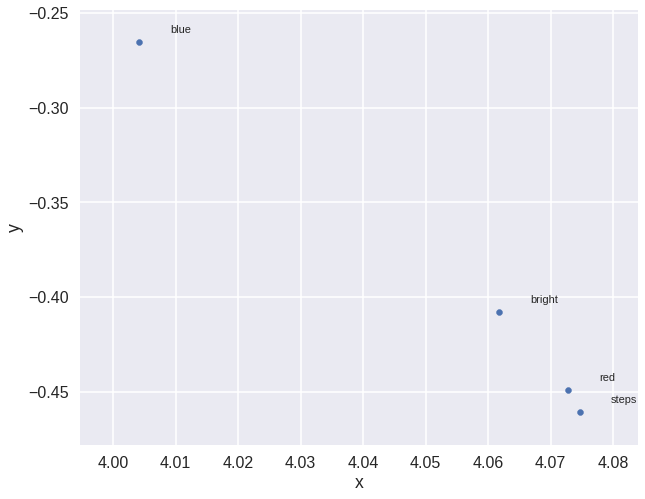

In [88]:
plot_region(x_bounds=(4.0, 4.2), y_bounds=(-0.5, -0.1))

**Food products are grouped nicely as well. Aerys (The Mad King) being close to "roasted" also looks sadly correct**

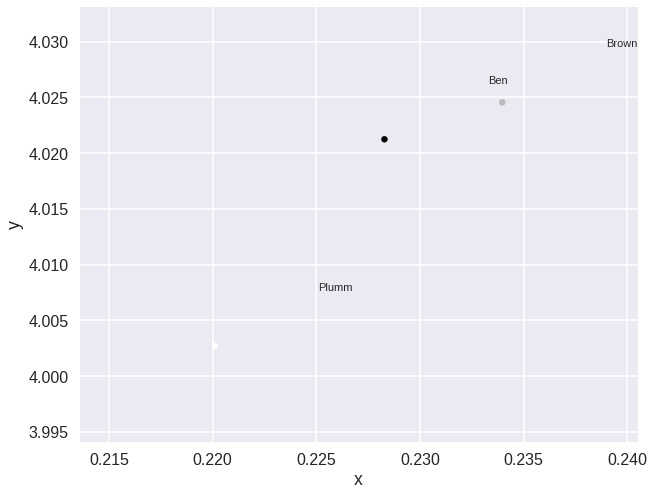

In [89]:
plot_region(x_bounds=(0, 1), y_bounds=(4, 4.5))

### Explore semantic similarities between book characters

**Words closest to the given word**

In [90]:
thrones2vec.most_similar("Stark")

2017-05-02 00:08:26,916 : INFO : precomputing L2-norms of word weight vectors


[(u'Eddard', 0.7671530842781067),
 (u'Robb', 0.6597634553909302),
 (u'Winterfell', 0.6580694913864136),
 (u'direwolf', 0.6253032684326172),
 (u'Benjen', 0.6221221089363098),
 (u'Lyanna', 0.620917558670044),
 (u'Brandon', 0.6204342842102051),
 (u'Karstark', 0.6181200742721558),
 (u'beheaded', 0.6173226237297058),
 (u'Rickard', 0.615590512752533)]

In [91]:
thrones2vec.most_similar("Aerys")

[(u'Mad', 0.7958230972290039),
 (u'Jaehaerys', 0.795149564743042),
 (u'Daeron', 0.7553389668464661),
 (u'Beggar', 0.7329099774360657),
 (u'reign', 0.732711672782898),
 (u'II', 0.7196937799453735),
 (u'Unworthy', 0.7106733322143555),
 (u'Cruel', 0.7088819742202759),
 (u'Targaryen', 0.7064501047134399),
 (u'Since', 0.7000645399093628)]

In [92]:
thrones2vec.most_similar("direwolf")

[(u'wolf', 0.6906076669692993),
 (u'Ghost', 0.6547658443450928),
 (u'pup', 0.6464484333992004),
 (u'Rickon', 0.6464434862136841),
 (u'Stark', 0.6253032684326172),
 (u'SHAGGYDOG', 0.6214169263839722),
 (u'Robb', 0.6211507320404053),
 (u'GHOST', 0.6167888641357422),
 (u'eagle', 0.6162689924240112),
 (u'OSHA', 0.5942133665084839)]

**Linear relationships between word pairs**

In [93]:
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = thrones2vec.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))
    return start2

In [94]:
nearest_similarity_cosmul("Stark", "Winterfell", "Riverrun")
nearest_similarity_cosmul("Jaime", "sword", "wine")
nearest_similarity_cosmul("Arya", "Nymeria", "dragons")

Stark is related to Winterfell, as Tully is related to Riverrun
Jaime is related to sword, as sipped is related to wine
Arya is related to Nymeria, as Dany is related to dragons


u'Dany'

## Tensorflow Version

In [51]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import os
import random
import zipfile

import numpy as np
from six.moves import urllib
from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow as tf
import unicodedata

In [99]:
vocabulary_size = 50000 
batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64    # Number of negative examples to sample.

In [81]:
def build_dataset(words, vocabulary_size):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count += 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words, vocabulary_size)

In [82]:
del words  # Hint to reduce memory.
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])

Most common words (+UNK) [['UNK', 0], (u'the', 88678), (u'and', 49825), (u'to', 39707), (u'of', 37674)]
Sample data [223, 9268, 25774, 1, 6157, 20673, 4, 1, 13749, 14079] [u'This', u'edition', u'contains', u'the', u'complete', u'text', u'of', u'the', u'original', u'hardcover']


In [86]:
print(len(data), len(count),  len(dictionary), len(reverse_dictionary))

1818103 29027 29027 29027


In [202]:
data_index = 0
def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1  # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [skip_window]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  # Backtrack a little bit to avoid skipping words in the end of a batch
  data_index = (data_index + len(data) - span) % len(data)
  return batch, labels

print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])
print('data_index:', data_index, len(data))

batch, labels = generate_batch(batch_size=8, num_skips=4, skip_window=2)
for i in range(8):
  #print(reverse_dictionary[batch[i]])
  print(batch[i], reverse_dictionary[batch[i]],
        '->', labels[i, 0], reverse_dictionary[labels[i, 0]])
print('data_index:', data_index)

Sample data [223, 9268, 25774, 1, 6157, 20673, 4, 1, 13749, 14079] [u'This', u'edition', u'contains', u'the', u'complete', u'text', u'of', u'the', u'original', u'hardcover']
data_index: 0 1818103
25774 contains -> 223 This
25774 contains -> 6157 complete
25774 contains -> 9268 edition
25774 contains -> 1 the
1 the -> 9268 edition
1 the -> 20673 text
1 the -> 25774 contains
1 the -> 6157 complete
data_index: 2


In [123]:
graph = tf.Graph()

with graph.as_default():

  # Input data.
  train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

  # Ops and variables pinned to the CPU because of missing GPU implementation
  #with tf.device('/cpu:0'):
    # Look up embeddings for inputs.
  embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  embed = tf.nn.embedding_lookup(embeddings, train_inputs)

  # Construct the variables for the NCE loss
  nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size], stddev=1.0 / math.sqrt(embedding_size)))
  nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

  # Compute the average NCE loss for the batch.
  # tf.nce_loss automatically draws a new sample of the negative labels each
  # time we evaluate the loss.
  loss = tf.reduce_mean(
      tf.nn.nce_loss(weights=nce_weights,
                     biases=nce_biases,
                     labels=train_labels,
                     inputs=embed,
                     num_sampled=num_sampled,
                     num_classes=vocabulary_size))

  # Construct the SGD optimizer using a learning rate of 1.0.
  optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

  # Compute the cosine similarity between minibatch examples and all embeddings.
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
      normalized_embeddings, valid_dataset)
  similarity = tf.matmul(
      valid_embeddings, normalized_embeddings, transpose_b=True)

  # Add variable initializer.
  init = tf.global_variables_initializer()

# Step 5: Begin training.
num_steps = 100001

with tf.Session(graph=graph) as session:
  # We must initialize all variables before we use them.
  init.run()
  print("Initialized")

  average_loss = 0
  for step in xrange(num_steps):
    batch_inputs, batch_labels = generate_batch(
        batch_size, num_skips, skip_window)
    feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

    # We perform one update step by evaluating the optimizer op (including it
    # in the list of returned values for session.run()
    _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += loss_val

    if step % 2000 == 0:
      if step > 0:
        average_loss /= 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print("Average loss at step ", step, ": ", average_loss)
      average_loss = 0

    # Note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      #for i in xrange(valid_size):
      #  valid_word = reverse_dictionary[valid_examples[i]]
        #top_k = 8  # number of nearest neighbors
        #nearest = (-sim[i, :]).argsort()[1:top_k + 1]
        #log_str = "Nearest to %s:" % valid_word
        #for k in range(top_k):
        #  print(nearest[k])
          #close_word = reverse_dictionary[nearest[k]]
          #log_str = "%s %s," % (log_str, close_word)
      #  print(log_str)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step  0 :  292.375061035
Average loss at step  2000 :  112.587373013
Average loss at step  4000 :  49.4489525907
Average loss at step  6000 :  31.581496913
Average loss at step  8000 :  22.9069736664
Average loss at step  10000 :  15.9854520178
Average loss at step  12000 :  12.9465013579
Average loss at step  14000 :  10.331236784
Average loss at step  16000 :  8.72830443335
Average loss at step  18000 :  7.86178521156
Average loss at step  20000 :  7.270838462
Average loss at step  22000 :  6.69144631326
Average loss at step  24000 :  6.3507791549
Average loss at step  26000 :  5.9506152178
Average loss at step  28000 :  5.6700954448
Average loss at step  30000 :  5.21669226456
Average loss at step  32000 :  5.03081494606
Average loss at step  34000 :  4.84462989557
Average loss at step  36000 :  4.90917465067
Average loss at step  38000 :  4.71857456565
Average loss at step  40000 :  4.66735955262
Average loss at step  42000 :  4.64747880316
Average loss 

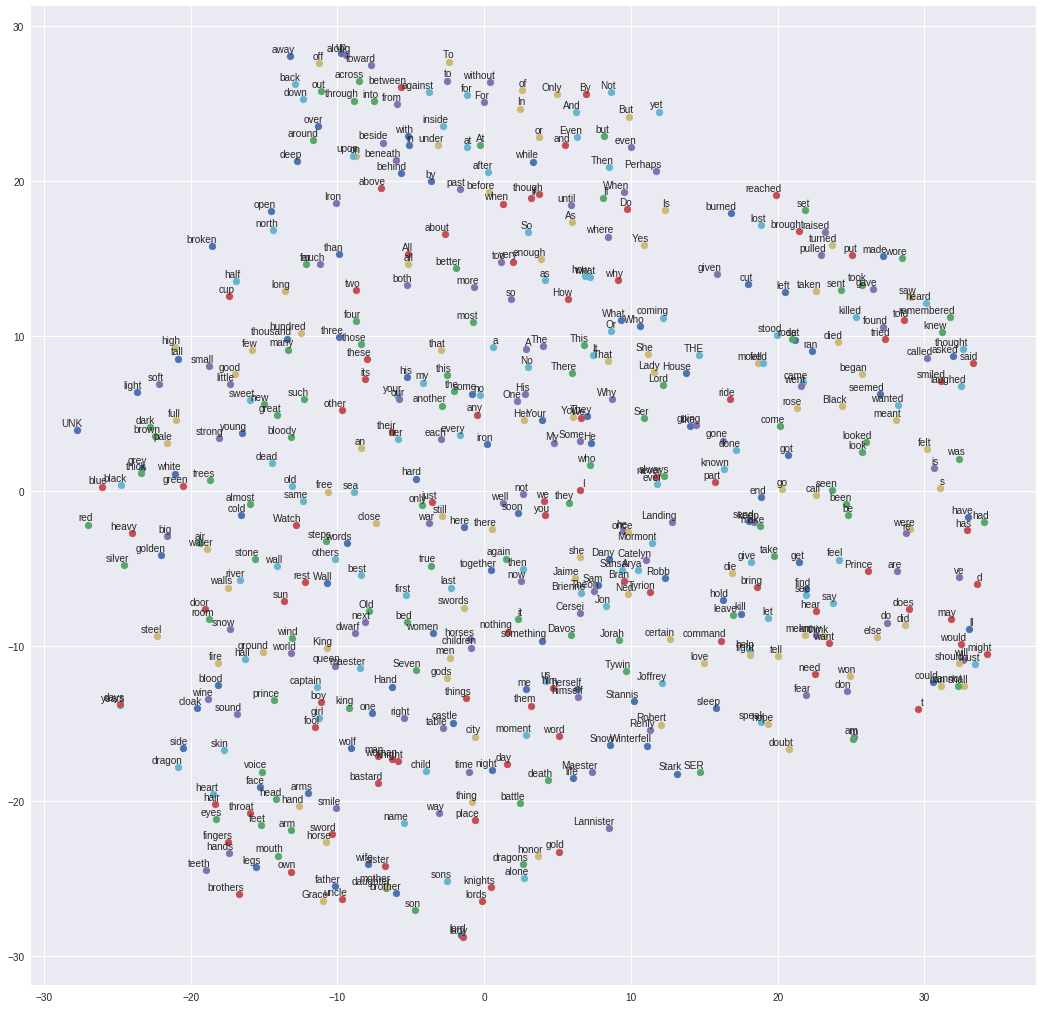

In [124]:
def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
  assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
  plt.figure(figsize=(18, 18))  # in inches
  for i, label in enumerate(labels):
    x, y = low_dim_embs[i, :]
    plt.scatter(x, y)
    plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')

  plt.savefig(filename)

try:
  from sklearn.manifold import TSNE
  import matplotlib.pyplot as plt

  tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
  plot_only = 500
  low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
  labels = [reverse_dictionary[i] for i in xrange(plot_only)]
  plot_with_labels(low_dim_embs, labels)

except ImportError:
  print("Please install sklearn, matplotlib, and scipy to visualize embeddings.")